<a href="https://colab.research.google.com/github/fatema373/Segmentation/blob/main/U_NET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import keras 
import tensorflow as tf
from keras import layers
import PIL
import cv2
import os
from keras.layers import add, ReLU,Input,Layer,Conv2D , Dropout, multiply,MaxPool2D, LeakyReLU,Concatenate,UpSampling2D,Conv2DTranspose,BatchNormalization,MaxPooling2D
from keras.models import Model, load_model
from PIL import Image
from IPython.core.display import Path
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
img_dir='/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/images'
mask_dir='/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/masks'

In [ ]:
def image_mask_images (path_image,path_mask): 
    imgs = list()
    masks = list()
    files_img = Path(path_image).glob('*')
    files_mask = Path(path_mask).glob('*')
    i=0
    for img,msk in zip(files_img,files_mask):
        if i>500:
            break
        else:
            i+=1
            im = Image.open(img)
            mask=Image.open(msk)
            #resize
            im = im.resize(size=(256,256))
            mask = mask.resize(size=(256,256))
            #norm
            # mask/=255
            im = np.array(im)
            mask=np.array(mask)
            mask=mask/255.
            im=im/255.
            if len(im.shape)==3&len(mask.shape)==3:
              if im.shape[2]==3&mask.shape[2]==3:
                imgs.append(im)
                masks.append(mask)
    return np.array(imgs),np.array(masks)
    # return np.array(train)
    

In [ ]:
imgs,masks=image_mask_images(img_dir,mask_dir)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split( imgs, masks, test_size=0.100, random_state=42)

In [ ]:
def convolution_operation(entered_input, filters=64):

    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    

    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    return act2

def encoder(entered_input, filters=64):

    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

def decoder(entered_input, skip, filters=64):

    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    # print(Upsample)
    Connect_Skip = Concatenate()([Upsample, skip])
    # print(Connect_Skip)
    out = convolution_operation(Connect_Skip, filters)
    return out

def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(3, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(input1, out)
    return model

In [ ]:
input_shape = (256, 256, 3)
model = U_Net(input_shape)
model.summary()

2022-12-14 21:23:41.837124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 21:23:41.934751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 21:23:41.935594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 21:23:41.936850: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 512), dtype=tf.float32, name=None), name='conv2d_transpose/BiasAdd:0', description="created by layer 'conv2d_transpose'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 1024), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 256), dtype=tf.float32, name=None), name='conv2d_transpose_1/BiasAdd:0', description="created by layer 'conv2d_transpose_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 512), dtype=tf.float32, name=None), name='concatenate_1/concat:0', description="created by layer 'concatenate_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 128), dtype=tf.float32, name=None), name='conv2d_transpose_2/BiasAdd:0', description="created by layer 'conv2d_transpose_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 256), dtype=tf.float32, name=None), name='concatenate_2/concat:0', desc

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(unet, to_file='UnetArchitecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy')
callbacks = [
    keras.callbacks.ModelCheckpoint("persons_U-Net.h5", save_best_only=True)
]

In [ ]:
epochs = 100
model.fit(X_train,y_train, epochs=epochs, callbacks=callbacks)

2022-12-14 21:23:46.813185: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-12-14 21:23:49.647110: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-12-14 21:23:58.117437: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-12-14 21:23:58.273384: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


15/15 [==============================] - 26s 808ms/step - loss: 0.6156
Epoch 2/100
15/15 [==============================] - 11s 737ms/step - loss: 0.5065
Epoch 3/100
15/15 [==============================] - 11s 736ms/step - loss: 0.4621
Epoch 4/100
15/15 [==============================] - 11s 737ms/step - loss: 0.4039
Epoch 5/100
15/15 [==============================] - 11s 736ms/step - loss: 0.4063
Epoch 6/100
15/15 [==============================] - 11s 735ms/step - loss: 0.3757
Epoch 7/100
15/15 [==============================] - 11s 735ms/step - loss: 0.3860
Epoch 8/100
15/15 [==============================] - 11s 737ms/step - loss: 0.3519
Epoch 9/100
15/15 [==============================] - 11s 736ms/step - loss: 0.3391
Epoch 10/100
15/15 [==============================] - 11s 741ms/step - loss: 0.3268
Epoch 11/100
15/15 [==============================] - 11s 737ms/step - loss: 0.3318
Epoch 12/100
15/15 [==============================] - 11s 736ms/step - loss: 0.3527
Epoch 13/100


In [ ]:
pred_masks = model.predict(X_test)

In [ ]:
model.evaluate(X_test,y_test)

2/2 [==============================] - 1s 174ms/step - loss: 0.3342


0.33416157960891724

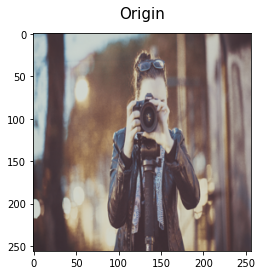

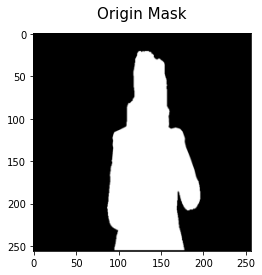

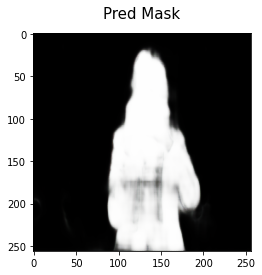

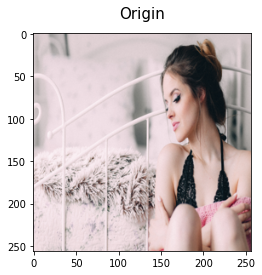

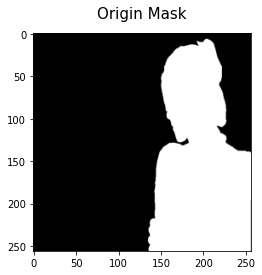

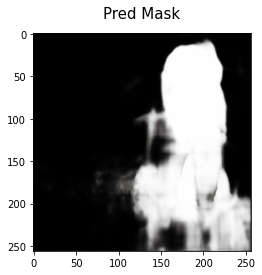

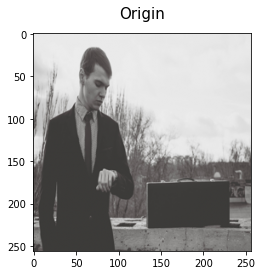

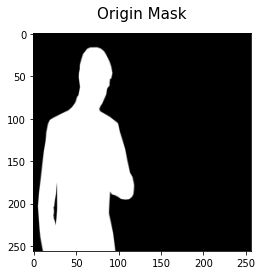

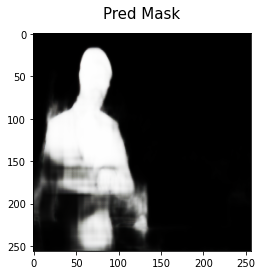

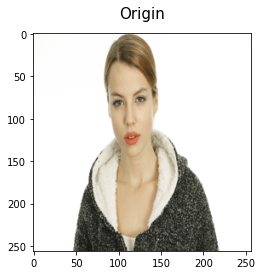

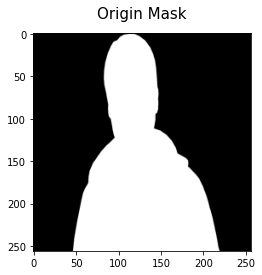

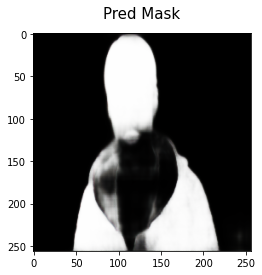

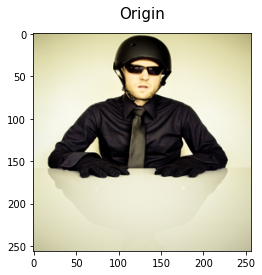

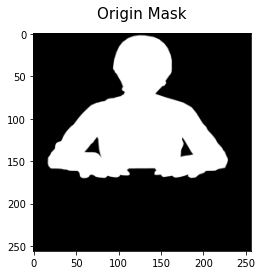

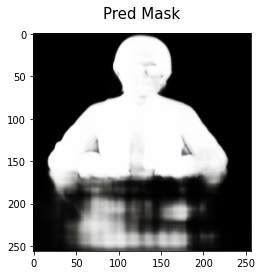

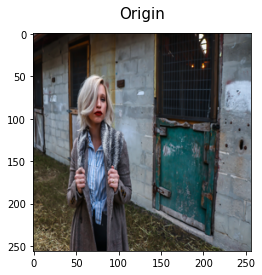

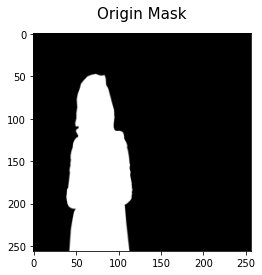

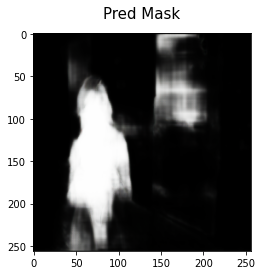

In [ ]:
def show_img(img,title):
    plt.imshow(img,cmap='gray')
    plt.title(title, fontsize=15, pad=15)
    plt.show()
i=5
# for i in range(5):
# plt.imshow(X_test[i])
# plt.show()
# plt.imshow(y_test[i])
# plt.show()
# plt.imshow(pred_masks[i])
# plt.show()

for img,msk,pred_mask in zip(X_test,y_test,pred_masks):
    if i>=0:
        show_img(img,'Origin')
        show_img(msk,'Origin Mask')
        show_img(pred_mask,'Pred Mask')
    i-=1

In [ ]:
model.save('unet.h5')

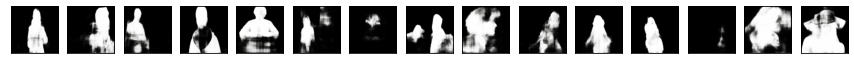

In [ ]:
n=15
plt.figure(figsize=(15,15))
for i in range(15):
    image, mask,pred_mask = X_test[i],y_test[i],pred_masks[i]
    ax = plt.subplot(2, n, i+1)
    plt.imshow(image)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(pred_mask)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()